# Agent-based Transportation Model

In [1]:
import logging

from polyline import decode
import requests
from shapely.geometry import LineString
from tqdm import tqdm

from dpd.modeling import PersonAgent, TransportationModel, OriginDestinationDataFrame, Zones
from dpd.osrm import OSRM
from dpd.shapely import random_point_in_polygon
from dpd.utils import epsg4326_to_aea

# logging.basicConfig(level=logging.INFO)

This is what was done in peopleModel.py

In [2]:
zones = Zones.from_uscensus("35", "2017")
od = OriginDestinationDataFrame.from_lodes("nm", "2017").sample(100)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3183: DtypeWarning: Columns (28,29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


This is what was done in routeModel.py

In [3]:
model = TransportationModel()

In [4]:
url_base = "http://localhost:5000"
osrm = OSRM(region="north-america/us/new-mexico", profile="car")
p = osrm.routed()
from time import sleep
sleep(1)

for index, row in tqdm(od.iterrows()):
    for i in range(row["S000"]):
        home = random_point_in_polygon(zones.loc[index[1]].geometry)
        work = random_point_in_polygon(zones.loc[index[0]].geometry)
        url = url_base + '/route/v1/driving/' + str(home.xy[0][0]) + ',' + str(home.xy[1][0]) + ';' + str(work.xy[0][0]) + ',' + str(work.xy[1][0])
        r = requests.get(url) # make this async
        polyline = r.json()['routes'][0]['geometry']
        person = PersonAgent(model=model, home=epsg4326_to_aea(home), work=epsg4326_to_aea(work))
        person.route_distance = r.json()['routes'][0]['distance']
        person.route_duration = r.json()['routes'][0]['duration']
        person.route_geometry = epsg4326_to_aea(LineString([tuple(reversed(point)) for point in decode(polyline)]))
        model.schedule.add(person)
p.kill()

100it [11:30,  3.77s/it]


This is what was done in simulation.py

In [5]:
for i in range(1000):
    model.step()

This is what was done in view.py

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


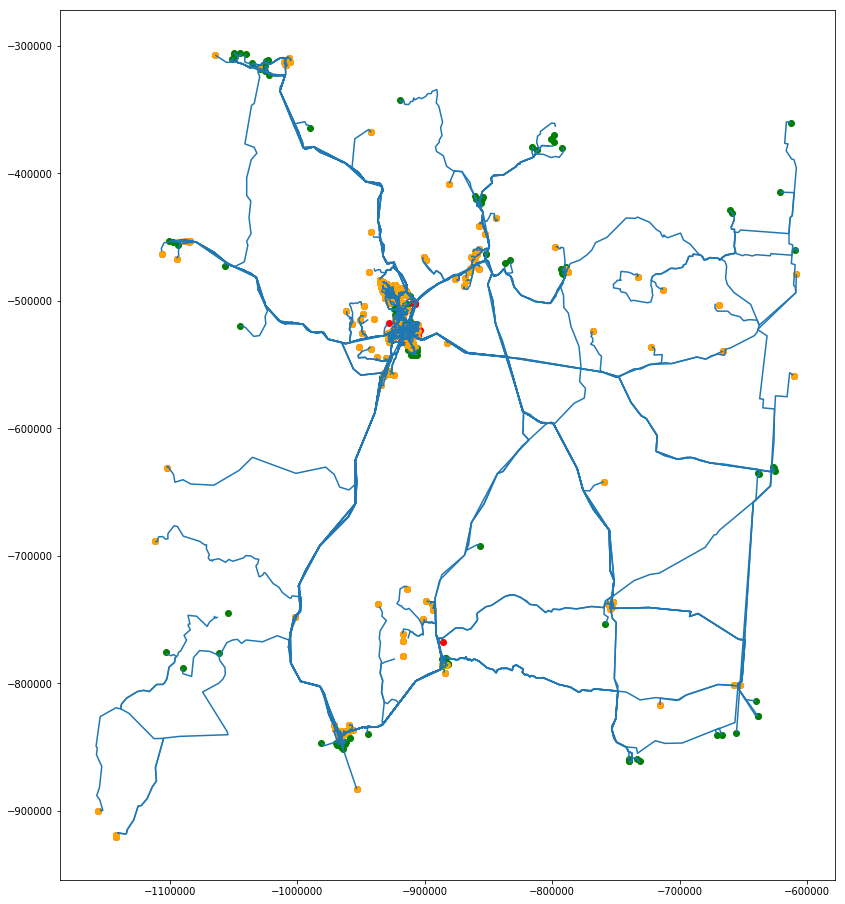

In [6]:
import geopandas
from matplotlib import pyplot

fig = pyplot.figure(figsize=(18, 16))
ax = fig.add_subplot(111)

gdf = geopandas.GeoDataFrame(model.schedule.agents)
gdf.crs = "EPSG:4326"
gdf["geometry"] = gdf[0].map (lambda x: x.route_geometry)
gdf.plot(ax=ax)
gdf["geometry"] = gdf[0].map (lambda x: x.home)
gdf.plot(ax=ax, color="r")
gdf["geometry"] = gdf[0].map (lambda x: x.work)
gdf.plot(ax=ax, color="g")
gdf["geometry"] = gdf[0].map (lambda x: x.pos)
gdf.plot(ax=ax, color="orange")


fig.show()